# Data Challenge 4

## Download data

In [5]:
#! pip install -q lalsuite
#! pip install -q gwpy
#! pip install -q pycbc
# -- Click "restart runtime" in the runtime menu

# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf

chs = ["H1:CHALLENGE3", "L1:CHALLENGE3"]
gwpy_strain = {}
pycbc_strain = {}

# -- for gwpy 
from gwpy.timeseries import TimeSeries
for ch in chs:
    gwpy_strain[ch] = TimeSeries.read('challenge3.gwf', channel=ch)

# -- for pycbc
from pycbc import frame
for ch in chs:
    pycbc_strain = frame.read_frame('challenge3.gwf', ch)

--2022-05-26 21:16:23--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘challenge3.gwf.3’

challenge3.gwf.3    100%[===================>] 244.92M  17.4MB/s    in 16s     

2022-05-26 21:16:39 (15.7 MB/s) - ‘challenge3.gwf.3’ saved [256815066/256815066]



## Sampling rate and duration

In [6]:
for ch in chs:
    duration = len(gwpy_strain[ch])*gwpy_strain[ch].dt
    sampling_rate = 1/gwpy_strain[ch].dt
    print("duration = {}".format(duration))
    print("sampling rate = {}".format(sampling_rate))

duration = 4096.0 s
sampling rate = 4096.0 1 / s
duration = 4096.0 s
sampling rate = 4096.0 1 / s


## Q-transform

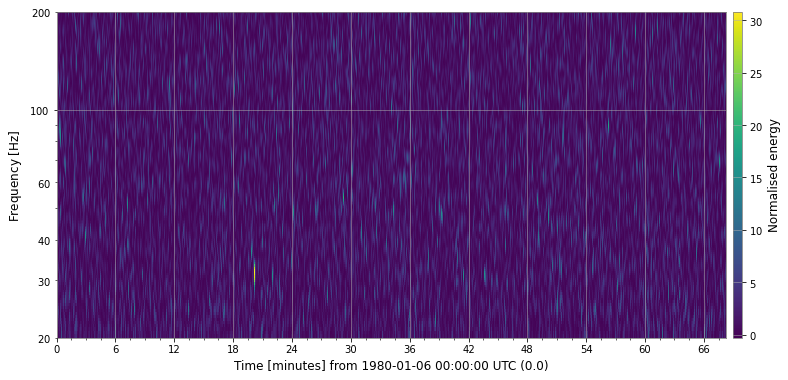

In [4]:
hq = gwpy_strain.q_transform(frange=(20, 200), qrange=(30, 120))
plot_hq = hq.plot()
ax = plot_hq.gca()
ax.set_yscale('log')
#ax.set_xlim(20*60, 21*60-15)
#ax.set_xlim(41*60, 42*60-5)
ax.colorbar(label="Normalised energy")

## Simple-To-Use matched-filtering code from sample

In [17]:
from pycbc import frame
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr

import numpy

import pylab
%matplotlib inline

def challenge_matched_filter(file_name,channel_name,mass):
    print("Looking at file {} with template mass {} M_sol".format(file_name,mass))
    #start = 0
    #end = start + 128
    #ts = read_frame(file_name, channel_name, start, end)
    ts = frame.read_frame(file_name, channel_name)
    ts = highpass(ts, 15.0)
    strain_ts = resample_to_delta_t(ts, 1.0/2048)
    conditioned_ts = strain_ts.crop(2, 2)
    psd_ts = conditioned_ts.psd(16)
    psd_ts = interpolate(psd_ts, conditioned_ts.delta_f)
    psd_ts = inverse_spectrum_truncation(psd_ts, int(4 * conditioned_ts.sample_rate),low_frequency_cutoff=15)
    
    hp_x, _ = get_fd_waveform(approximant="IMRPhenomD",
                                mass1=mass, mass2=mass,
                                f_lower=20.0, delta_f=conditioned_ts.delta_f)
    hp_x.resize(len(psd_ts))

    # For each observatory use this template to calculate the SNR time series
    snr_x = matched_filter(hp_x, conditioned_ts, psd=psd_ts, low_frequency_cutoff=20).crop(5, 4)

    pylab.figure(figsize=[14, 4])
    pylab.plot(snr_x.sample_times, abs(snr_x), label='H1')
    pylab.title('SNR Time Series')
    pylab.grid()
    pylab.xlabel('Time (s)')
    pylab.ylabel('Signal-to-noise (SNR)')
    pylab.show()
    
    peak_x = numpy.argmax(abs(snr_x))
    snr_x_peak = snr_x[peak_x]
    time_x = snr_x.sample_times[peak_x]
    print("We found a possible signal at {}s with SNR {}".format(time_x, abs(snr_x_peak)))

    chisq_x = {}
    nbins = 26
    chisq_x = power_chisq(hp_x, conditioned_ts, nbins, psd_ts, low_frequency_cutoff=20.0)
    chisq_x = chisq_x.crop(5, 4)
    print(chisq_x)

    dof_x = nbins * 2 - 2
    chisq_x /= dof_x


    # The rho-hat term above is named "newsnr" here
    nsnr_x = newsnr(abs(snr_x), chisq_x)

    # Plot the new SNR timeseries
    pylab.figure(figsize=[14, 4])
    pylab.plot(snr_x.sample_times, nsnr_x, label='H1')
    pylab.title('NewSNR Timeseries')
    pylab.grid()
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()
    
    peak_x = numpy.argmax(abs(nsnr_x))
    nsnr_x_peak = nsnr_x[peak_x]
    time_x = snr_x.sample_times[peak_x]
    print("We found a signal at {}s with (reweighed) SNR {}".format(time_x, abs(nsnr_x_peak)))
    

files = ['challenge3.gwf']
channels = ['H1:CHALLENGE3','L1:CHALLENGE3']

Looking at file challenge3.gwf with template mass 10 M_sol


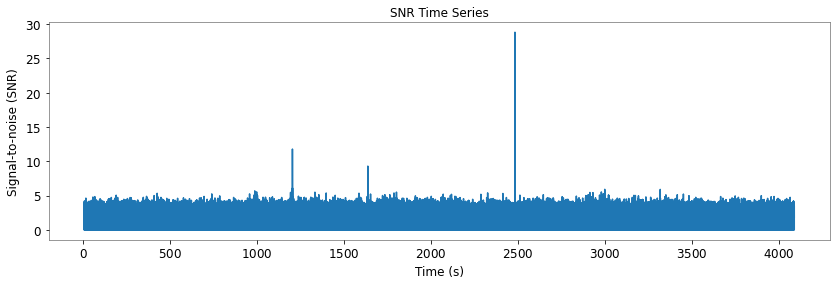

We found a possible signal at 2483.96875s with SNR 28.822308214167993
[51.29742531 51.7741234  53.0484223  ... 46.87452273 47.6233018
 49.55618004]


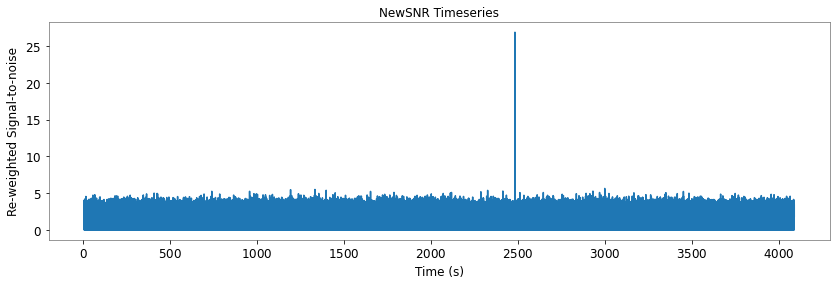

We found a signal at 2483.96875s with (reweighed) SNR 26.870953418426534


In [17]:
challenge_matched_filter(files[0],channels[0], 10)

Merger time 1980-01-06 00:41:23 UTC

SNR = 26.9